#  Book Recommender---Part1 (Web scraping,Data Wrangling and EDA)

In [28]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import pickle
import time, requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm_notebook as tqdm
import os

#pakages for webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as ec
from selenium.common.exceptions import (
    TimeoutException, NoSuchElementException, StaleElementReferenceException, WebDriverException
)

In [2]:
URLSTART="https://www.goodreads.com" 
id_from_url = re.compile(r"^.*/([0-9]+).*$")


# 1. Web scraping data from goodreads.com

I choose the top 3000 books from the list of  [Best_Young_Adult_Books](https://www.goodreads.com/list/show/43.Best_Young_Adult_Books) to build the dataset and the recommender sysytem.

# 1.1 Get the books urls from the book list

In [3]:
#get urls of all the books in the list
def get_books_urls(url):
    books_urls=[]
    html=requests.get(url)
    d=BeautifulSoup(html.text, 'lxml')
    #the number of pages in the book list
    max_page=int(d.find(class_="pagination").find_all("a")[-2].text)
    #fetch books urls from up to 30 web pages(up to 3000 books,100 books per page)  
    page_num=min(30,max_page)
    print(f'There are {max_page} pages in the booklist,we will fetch book urls from the top {page_num} pages')    
    for i in tqdm(range(1,page_num+1),desc="fetching book url"):
        #print(f"getting the book urls from page {i}")
        if i!=1:
            html=requests.get(books_url+f'?page={i}')
        d=BeautifulSoup(html.text, 'lxml')        
        for e in d.select('.bookTitle'):
            books_urls.append(URLSTART+e['href'])
        html.close()
    return books_urls
    

In [4]:
books_url="https://www.goodreads.com/list/show/43.Best_Young_Adult_Books"
books_urls=get_books_urls(books_url)

There are 121 pages in the booklist,we will fetch book urls from the top 30 pages


# 1.2 Get the books metadta

In [5]:
# get metadata of a booklist
def scrap_books(urls):
    bookIDs=[]
    titles=[]
    ratings=[]
    authorNames=[]
    authorIDs=[]
    ratingCounts=[]
    reviewCounts=[]
    descriptions=[]
    fail_to_get=[]
    for url in tqdm(urls,desc="fetching book metadata"):
        book=scrap_book(url)
        if not book:
            fail_to_get.append(url)
            continue
        bookIDs.append(book['bookID'])
        titles.append(book['title'])
        ratings.append(book['rating'])
        authorNames.append(book['authorName'])
        authorIDs.append(book['authorID'])
        ratingCounts.append(book['ratingCount'])
        reviewCounts.append(book['reviewCount'])
        descriptions.append(book['description'])
    books={'bookID':bookIDs,
           'title':titles,
           'rating':ratings,
           'authorName':authorNames,
           'authorID':authorIDs,           
           'ratingCount':ratingCounts,
           'reviewCount':reviewCounts,
           'descriptions':descriptions}
    return books,fail_to_get
    

In [6]:
#get matadata of a single book (BookID,authorName,authorID,rating,ratingCount,reviewCount,description text)
def scrap_book(url):
    #print(url)
    html=requests.get(url)
    d=BeautifulSoup(html.text, 'html.parser')
    bookID=id_from_url.match(url).group(1)
    title = d.find(id="bookTitle")
    if not title: 
        return None
    else:
        title=title.text.strip()    
    rating = d.find(itemprop="ratingValue").text.strip()
    authorName = d.find(class_="authorName").text
    authorID=id_from_url.match(d.find(class_="authorName").get('href')).group(1)
    ratingCount=d.select("meta[itemprop='ratingCount']")[0]["content"]
    reviewCount=d.select("meta[itemprop='reviewCount']")[0]["content"]
    description=d.select("div[id='description']")
    if not description:
        return None
    else:
        description=d.select("div[id='description']")[0].find_all('span')[-1].text
    book={}
    book['bookID']=bookID
    book['title']=title
    book['rating']=rating
    book['authorName']=authorName
    book['authorID']=authorID    
    book['ratingCount']=ratingCount
    book['reviewCount']=reviewCount
    book['description']=description    
    return book    


In [7]:
books_list,fail_to_get=scrap_books(books_urls)

In [8]:
#check the books failed to fetch and remove them from book list
print(f'fail to fetch {len(fail_to_get)} books')
fail_list=[]
for url in fail_to_get:
    bookID=id_from_url.match(url).group(1)
    fail_list.append(bookID)
    #books_urls.remove(url)

fail to fetch 30 books


In [9]:
#data wrangling
books_df=pd.DataFrame(books_list)
books_df['rating']=books_df['rating'].astype(float)
books_df['ratingCount']=books_df['ratingCount'].astype(int)
books_df['reviewCount']=books_df['reviewCount'].astype(int)
print(f'There are {books_df.duplicated().sum()} duplicated rows')

There are 0 duplicated rows


In [10]:
books_df.sample(5)

,bookID,title,rating,authorName,authorID,ratingCount,reviewCount,descriptions
601,48592799,Ice Dragon,3.33,D.K. Holmberg,7231848,3984,57,An Epic Fantasy Adventure When a mysterious st...
1030,235466,Someday This Pain Will Be Useful to You,3.68,Peter Cameron,110982,12409,1437,It’s time for eighteen-year-old James Sveck to...
1166,15779957,Render,4.03,Stephanie Fleshman,6453495,30,20,A betrayal born of bloodA curse for a giftA lo...
1514,20803953,Bully,4.09,Penelope Douglas,7139136,98736,7090,"My name is Tate. He doesn't call me that, thou..."
730,17275769,Scepter of Faith,4.41,Chris Smith,7111433,117,30,"For God, we fight; all angels have heard the c..."


In [11]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970 entries, 0 to 2969
Data columns (total 8 columns):
bookID          2970 non-null object
title           2970 non-null object
rating          2970 non-null float64
authorName      2970 non-null object
authorID        2970 non-null object
ratingCount     2970 non-null int32
reviewCount     2970 non-null int32
descriptions    2970 non-null object
dtypes: float64(1), int32(2), object(5)
memory usage: 162.5+ KB


In [12]:
#save the data
books_df.to_csv('./goodreads/books.csv',index=False)
with open('./goodreads/fail_list.pikle','wb') as handle:
    pickle.dump(fail_list,handle)
with open('./goodreads/books_urls.pikle','wb') as handle:
    pickle.dump(books_urls,handle)

# 1.3 Fetch the ratings data

In [13]:
#get up to 300 ratings from a single book 
def scrape_book_ratings(book_url):
    browser = webdriver.Chrome()
    browser.set_page_load_timeout(30)
    browser.get(book_url)
    rating=[]
    have_review=True
    pre_start=0    
    while have_review:
        try:
            d=BeautifulSoup(browser.page_source, 'html.parser')
            start,end=d.find(class_="bookReviewsPaginationCount").text[10:].split("-")
        except Exception:#if error,then skip this book
            break
        if start!=pre_start: #if new review page loaded,then go forward to download the ratings on new page
            for review in d.find_all(class_="review"):
                try:
                    user_id = review.find(class_="user").get("href")[11:].split("-")[0]
                    stars = len(review.find(class_="staticStars").find_all(class_="p10"))
                    rating.append((user_id,stars))
                except Exception:#if error happen, skip this rating
                    continue
            pre_start=start
            pre_end=end
            try:  # Try to find the next_page button
                next_page = browser.find_element_by_class_name("next_page")
                # Check if button is click-able,if so click it
                if next_page.tag_name == "a":
                    browser.execute_script("arguments[0].click();",next_page)                    
                else:
                    have_review=False
            except NoSuchElementException: #if there isn't next_page element on the page,break the while loop
                print("WARNING: There is no next page!")
                have_review=False
                break
    browser.quit()
    return rating 

In [14]:
#get the ratings of the books in the list, the ratings 
def scrap_books_ratings(urls):
    books_ratings={}
    fail_to_get=[]
    for url in tqdm(urls,desc="fetching book ratings"):
        bookID=id_from_url.match(url).group(1)
        if bookID in fail_list:
            continue
        book_ratings=scrape_book_ratings(url)
        if not book_ratings:
            fail_to_get.append(url)
            continue        
        books_ratings[bookID]=book_ratings
    return books_ratings,fail_to_get

In [15]:
#It takes more than 18 hours to fetch rating data for 3000 books,
#so I fetch it by batches and save them into local files for later loading and combining
#ratings,_=scrap_books_ratings(books_urls)

#just a demo of scraping rating data as below
books_ratings1,_=scrap_books_ratings(books_urls[:10])

In [16]:
#load the previously fetched and saved ratings data
bookID=[]
userID=[]
rating=[]
for i in range(1,7):
    ratingfile=os.path.join('.\goodreads',f'rating{i}.pickle')
    ratings=pickle.load(open(ratingfile,'rb'))
    for key in ratings.keys():
        for item in ratings[key]:
            bookID.append(key)
            userID.append(item[0])
            rating.append(item[1])
ratings=pd.DataFrame({'bookID':bookID,'userID':userID,'rating':rating})
user_rating_count=ratings.groupby(by='userID',as_index=False).agg({'rating':pd.Series.count}).sort_values('rating',ascending = False)
#only keep the users who rated no less than 5 books
final_users=user_rating_count[user_rating_count['rating']>=5]
final_ratings=ratings[ratings['userID'].isin(final_users.userID)]


In [17]:
#check duplicate data and remove them
print(f'There are {final_ratings.duplicated(keep=False).sum()} dupulicated rows')
final_ratings=final_ratings.drop_duplicates(keep='first')
final_ratings=final_ratings.reset_index(drop=True)

There are 2029 dupulicated rows


In [18]:
final_ratings.sample(5)

,bookID,userID,rating
29613,37435,49089020,5
2051,13335037,7030272,4
28367,100915,34178791,5
76130,7991200,283407,4
29862,10917,22220347,4


In [19]:
final_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331648 entries, 0 to 331647
Data columns (total 3 columns):
bookID    331648 non-null object
userID    331648 non-null object
rating    331648 non-null int64
dtypes: int64(1), object(2)
memory usage: 7.6+ MB


In [20]:
final_ratings.to_csv('./goodreads/final_ratings.csv',index=False)

# 2. Explore the data 

## 2.1 Books dataset 

In [21]:
books_df=pd.read_csv("./goodreads/books.csv")

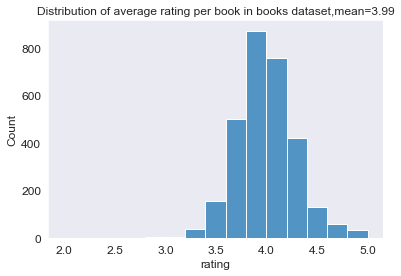

In [22]:
rating_mean=round(books_df['rating'].mean(),2)
sns.histplot(books_df['rating'],bins=15)
plt.title(f'Distribution of average rating per book in books dataset,mean={rating_mean}')
plt.show()

## 2.2 Ratings dataset 

In [23]:
final_ratings=pd.read_csv("./goodreads/final_ratings.csv")

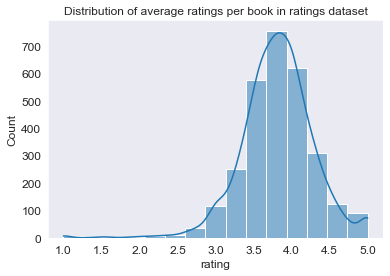

In [24]:
agg = final_ratings.groupby(by= 'bookID', as_index=False).agg({'rating':pd.Series.mean})
sns.histplot(agg['rating'],bins=15,kde=True)
plt.title('Distribution of average ratings per book in ratings dataset')
plt.show()

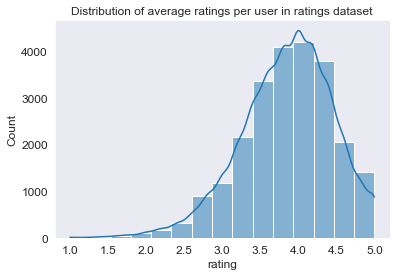

In [25]:
agg = final_ratings.groupby(by= 'userID', as_index=False).agg({'rating':pd.Series.mean})
sns.histplot(agg['rating'],bins=15,kde=True)
plt.title('Distribution of average ratings per user in ratings dataset')
plt.show()

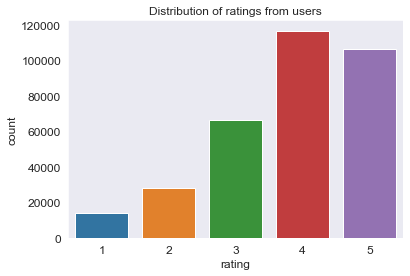

In [26]:
sns.countplot(x="rating" , data=final_ratings)
plt.title('Distribution of ratings from users')
plt.show()

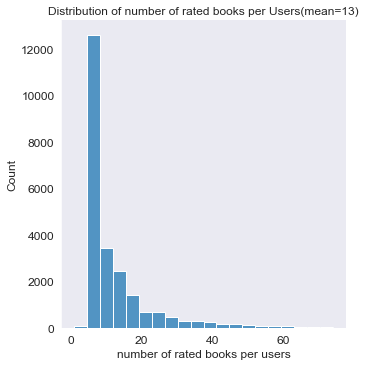

In [27]:
mean_rated=int(final_ratings['userID'].value_counts().mean())
distr = final_ratings.groupby(by= 'userID', as_index=False).agg({'rating':pd.Series.count})
distr=distr[distr['rating']<75]
sns.displot(distr['rating'],bins=20)
plt.title(f'Distribution of number of rated books per Users(mean={mean_rated})')
plt.xlabel('number of rated books per users') 
plt.show()